In [1]:
# Import necessary libraries and check GPU availability
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Check for GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available and will be used.")
else:
    print("GPU is not available, using CPU instead.")

GPU is available and will be used.


In [2]:
# Dataset paths (fold5-selected)
train_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold5_AUG/Train'
valid_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold5/Valid'
test_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold5/Test'

In [3]:
img_size = (224, 224)
batch_size = 16

In [4]:
# Function to create data augmentation pipelines
def augment_class_specific(class_name):
    if class_name in ['Chickenpox', 'Monkeypox']:
        # More aggressive augmentations for Chickenpox and Monkeypox
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=60,
            width_shift_range=0.5,
            height_shift_range=0.5,
            shear_range=0.4,
            zoom_range=0.5,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.5, 1.5],
            fill_mode='nearest',
            preprocessing_function=lambda img: tf.image.random_contrast(img, lower=0.8, upper=1.2)
        )
    else:
        # Lighter augmentations for other classes
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.4,
            height_shift_range=0.4,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            brightness_range=[0.7, 1.3],
            fill_mode='nearest'
        )

# Test data augmentation (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Function to load data with class-specific augmentations
def load_data():
    train_datagen = augment_class_specific("Chickenpox")
    validation_datagen = augment_class_specific("Monkeypox")
    
    train_generator = train_datagen.flow_from_directory(
        train_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        valid_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = load_data()

Found 7532 images belonging to 6 classes.
Found 154 images belonging to 6 classes.
Found 63 images belonging to 6 classes.


In [6]:
# Check class indices to ensure they are correct
print(f"Class indices for the training data: {train_generator.class_indices}")

Class indices for the training data: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}


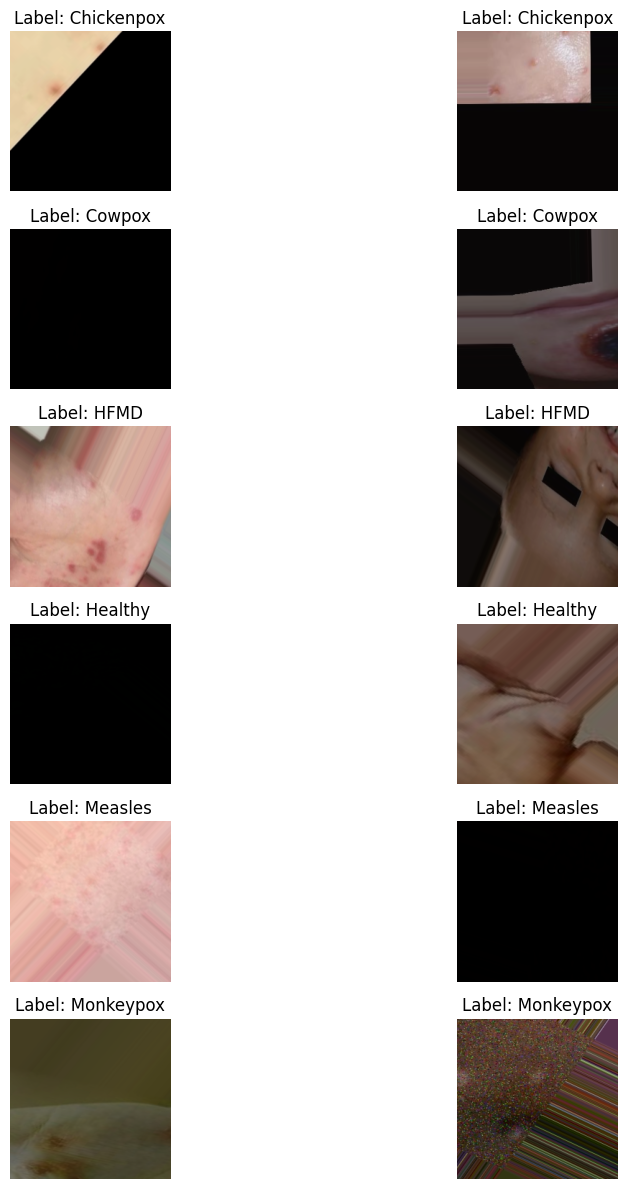

In [7]:
def plot_images_per_class(generator, num_images_per_class=2):
    # Invert the class_indices dictionary to get label -> class name mapping
    class_indices = {v: k for k, v in generator.class_indices.items()}
    num_classes = len(class_indices)
    
    # Initialize a dictionary to store images for each class
    images_per_class = {class_name: [] for class_name in class_indices.values()}

    # Loop until we have collected enough images for each class
    while any(len(images) < num_images_per_class for images in images_per_class.values()):
        images, labels = next(generator)
        
        # Process each image in the batch
        for img, label in zip(images, labels):
            class_label = np.argmax(label)  # Find the index of the one-hot encoded label
            class_name = class_indices[class_label]  # Get the class name from the class indices
            
            # Only add if we haven't collected enough images for this class
            if len(images_per_class[class_name]) < num_images_per_class:
                images_per_class[class_name].append(img)
    
    # Now that we have enough images, let's plot them
    plt.figure(figsize=(12, num_classes * 2))  # Adjust the figure size based on the number of classes
    img_idx = 1
    for class_name, images in images_per_class.items():
        for img in images:
            plt.subplot(num_classes, num_images_per_class, img_idx)
            img_idx += 1
            
            # Scale the image if necessary
            if img.max() > 1:
                img = img / 255.0
            
            plt.imshow(img)
            plt.title(f"Label: {class_name}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 2 images from each class from the training set
plot_images_per_class(train_generator, num_images_per_class=2)

In [8]:
# Compute class weights to handle imbalance
labels = train_generator.classes
class_weights_densenet = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(labels), 
                                                  y=labels)
class_weights_dict_densenet = dict(enumerate(class_weights_densenet))

In [9]:
# Build the DenseNet model
def build_densenet_model(input_shape=(224, 224, 3), num_classes=6):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Fine-tune the last 100 layers of DenseNet
    for layer in base_model.layers[-100:]:
        layer.trainable = True
    
    # Add custom layers for classification
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Build the model
model_densenet = build_densenet_model()

# Callbacks for early stopping, learning rate reduction, and model checkpoint
checkpoint_densenet = ModelCheckpoint("best_model_densenet.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_densenet = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler_densenet = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model with class weights and callbacks
history_densenet = model_densenet.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights_dict_densenet,
    callbacks=[checkpoint_densenet, early_stopping_densenet, lr_scheduler_densenet]
)

# Evaluate the model on the test set
test_loss_densenet, test_acc_densenet = model_densenet.evaluate(test_generator)
print(f"Test accuracy: {test_acc_densenet}")

# Save the final model
model_densenet.save('final_densenet_model.keras')

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729446457.817136     116 service.cc:145] XLA service 0x7e5088120ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729446457.817197     116 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729446551.302840     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


471/471 ━━━━━━━━━━━━━━━━━━━━ 454s 636ms/step - accuracy: 0.2950 - loss: 2.2584 - val_accuracy: 0.4870 - val_loss: 1.6407 - learning_rate: 1.0000e-04
Epoch 2/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 162s 339ms/step - accuracy: 0.4568 - loss: 1.5266 - val_accuracy: 0.6429 - val_loss: 1.2956 - learning_rate: 1.0000e-04
Epoch 3/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 158s 332ms/step - accuracy: 0.5205 - loss: 1.2292 - val_accuracy: 0.6234 - val_loss: 1.6083 - learning_rate: 1.0000e-04
Epoch 4/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 201s 331ms/step - accuracy: 0.5940 - loss: 1.0274 - val_accuracy: 0.6169 - val_loss: 1.1892 - learning_rate: 1.0000e-04
Epoch 5/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 158s 331ms/step - accuracy: 0.6078 - loss: 0.9745 - val_accuracy: 0.6104 - val_loss: 1.1922 - learning_rate: 1.0000e-04
Epoch 6/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 160s 336ms/step - accuracy: 0.6568 - loss: 0.8375 - val_accuracy: 0.7078 - val_loss: 0.8871 - learning_rate: 1.0000e-04
Epoch 7/50
471/471 ━━━━━━━━━━━━━━━━━━━━ 159s 333ms/

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step
Classification Report for DenseNet121 Model:
              precision    recall  f1-score   support

  Chickenpox       0.75      0.86      0.80         7
      Cowpox       0.86      0.86      0.86         7
        HFMD       0.88      1.00      0.94        15
     Healthy       0.91      1.00      0.95        10
     Measles       1.00      0.50      0.67         6
   Monkeypox       0.94      0.89      0.91        18

    accuracy                           0.89        63
   macro avg       0.89      0.85      0.85        63
weighted avg       0.90      0.89      0.88        63

Precision: 0.8971012647483235
Recall: 0.8888888888888888
F1 Score: 0.88322940287226


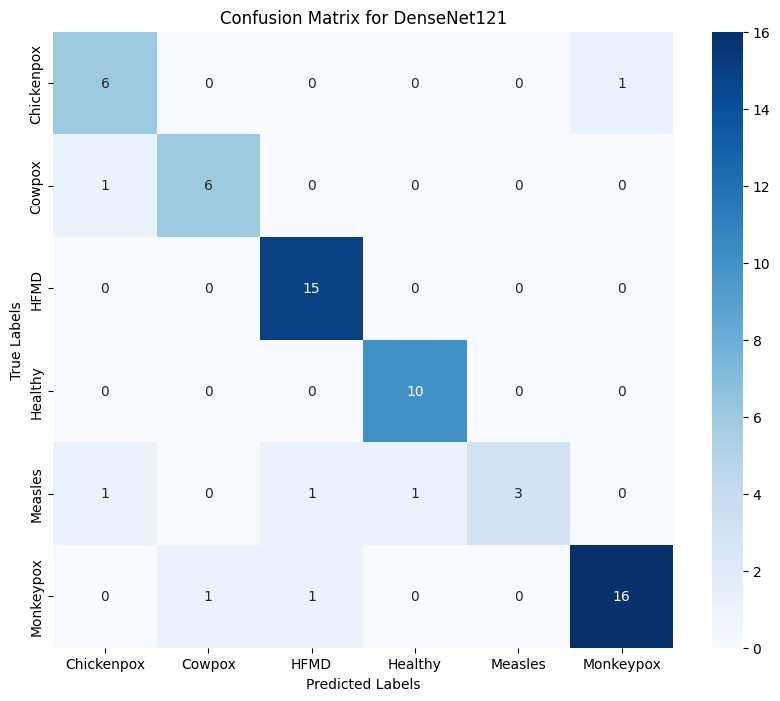

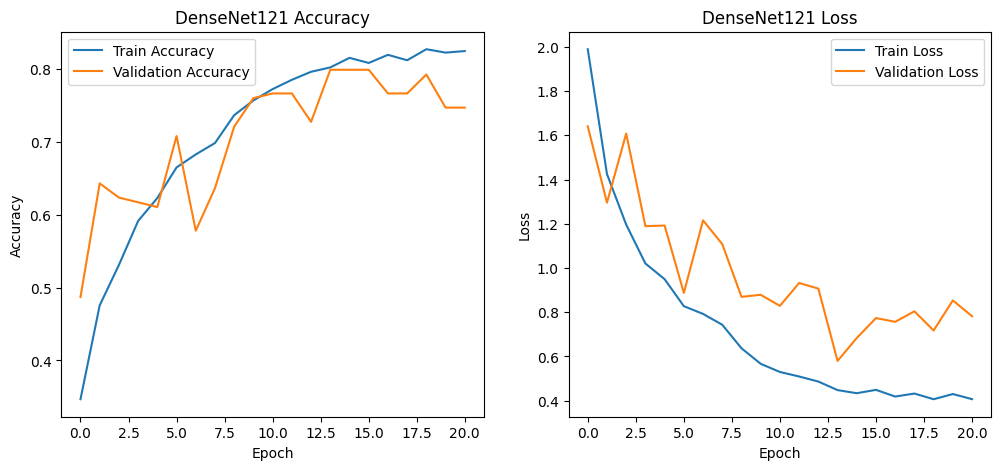

In [10]:
# Predictions on the test set
preds_densenet = model_densenet.predict(test_generator)
y_preds_densenet = np.argmax(preds_densenet, axis=1)
y_true_densenet = test_generator.classes

# Classification report
print("Classification Report for DenseNet121 Model:")
print(classification_report(y_true_densenet, y_preds_densenet, target_names=test_generator.class_indices.keys()))

# Compute accuracy, precision, recall, and F1-score
accuracy_densenet = accuracy_score(y_true_densenet, y_preds_densenet)
precision_densenet = precision_score(y_true_densenet, y_preds_densenet, average='weighted', zero_division=0)
recall_densenet = recall_score(y_true_densenet, y_preds_densenet, average='weighted', zero_division=0)
f1_densenet = f1_score(y_true_densenet, y_preds_densenet, average='weighted', zero_division=0)

print(f"Precision: {precision_densenet}")
print(f"Recall: {recall_densenet}")
print(f"F1 Score: {f1_densenet}")

# Confusion matrix
cm_densenet = confusion_matrix(y_true_densenet, y_preds_densenet)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_densenet, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for DenseNet121')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Function to plot training history
def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot training history
plot_training_history(history_densenet, model_name="DenseNet121")